In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from scipy import interp

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
import pandas as pd
import numpy as np
import csv
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
%matplotlib inline
pd.set_option('display.width',5000)
%config InlineBackend.figure_format = 'svg'
#config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 300
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv('Felix_Hernandez.csv')

In [4]:
df = df[df.pitch_type != 'null']

In [5]:
df = pd.get_dummies(df, columns=["pitch_type"])
df = pd.get_dummies(df, columns=['p_throws'])
df = pd.get_dummies(df, columns=["stand"])
df = pd.get_dummies(df, columns=["inning_topbot"])
df = pd.get_dummies(df, columns=["if_fielding_alignment"])
df = pd.get_dummies(df, columns=["of_fielding_alignment"])
df = pd.get_dummies(df, columns=["events"])
df.rename(columns={'type':'called'}, inplace=True)
df = pd.get_dummies(df, columns=["called"])

In [6]:
df.rename(columns={'inning_topbot_Bot':'inning_bot'}, inplace=True)
df.rename(columns={'inning_topbot_Top':'inning_top'}, inplace=True)
df.rename(columns={'if_fielding_alignment_Infield shift':'if_shift'}, inplace=True)
df.rename(columns={'if_fielding_alignment_Standard':'if_standard'}, inplace=True)
df.rename(columns={'if_fielding_alignment_Strategic':'if_strategic'}, inplace=True)
df.rename(columns={'of_fielding_alignment_4th outfielder':'of_fourth'}, inplace=True)
df.rename(columns={'of_fielding_alignment_Standard':'of_standard'}, inplace=True)
df.rename(columns={'of_fielding_alignment_Strategic':'of_strategic'}, inplace=True)
df.drop('if_fielding_alignment_null',axis=1,inplace=True)
df.drop('of_fielding_alignment_null',axis=1,inplace=True)

In [7]:
df['breaking'] = df['pitch_type_SL'] + df['pitch_type_CU'] 
df['offspeed'] = df['pitch_type_CH'] 
df['fastball'] = df['pitch_type_FF'] + df['pitch_type_SI'] + df['pitch_type_FC']
df['run_diff'] = df['bat_score'] - df['fld_score']
df['count_diff'] = df['balls'] - df['strikes']

In [8]:
df['pitch']=0
df['pitch'][df.offspeed == 1] = 2
df['pitch'][df.breaking == 1] = 1

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df['on_3b'] = df['on_3b'].replace(['null'], 0)
df['on_2b'] = df['on_2b'].replace(['null'], 0)
df['on_1b'] = df['on_1b'].replace(['null'], 0)
df.on_3b = df.on_3b.astype(int)
df.on_2b = df.on_2b.astype(int)
df.on_1b = df.on_1b.astype(int)
maxVal = 1
df['on_3b'][df['on_3b'] >= maxVal] = maxVal
df['on_2b'][df['on_2b'] >= maxVal] = maxVal
df['on_1b'][df['on_1b'] >= maxVal] = maxVal

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
conditions = [
    (df['balls'] == 0) & (df['strikes'] == 0),
    (df['balls'] == 0) & (df['strikes'] == 1),
    (df['balls'] == 0) & (df['strikes'] == 2),
    (df['balls'] == 1) & (df['strikes'] == 0),
    (df['balls'] == 1) & (df['strikes'] == 1),
    (df['balls'] == 1) & (df['strikes'] == 2),
    (df['balls'] == 2) & (df['strikes'] == 0),
    (df['balls'] == 2) & (df['strikes'] == 1),
    (df['balls'] == 2) & (df['strikes'] == 2),
    (df['balls'] == 3) & (df['strikes'] == 0),
    (df['balls'] == 3) & (df['strikes'] == 1),
    (df['balls'] == 3) & (df['strikes'] == 2)
]
choices = ['0-0', '0-1', '0-2','1-0','1-1','1-2','2-0','2-1','2-2','3-0','3-1','3-2']
df['count'] = np.select(conditions, choices)
df = pd.get_dummies(df, columns=["count"])

In [ ]:
df.head(1)

In [11]:
df.zone[df.zone == 'null'] = 14
df.zone = df.zone.astype(int)
df.release_speed[df.release_speed == 'null'] = 90
df.release_speed = df.release_speed.astype(float)
df['prev_pitch'] = df['pitch'].shift(-1)
df['prev_pitch'] = df['prev_pitch'].fillna(0)
df['prev_speed'] = df['release_speed'].shift(-1)
df['prev_speed'] = df['prev_speed'].fillna(90)
df['prev_zone'] = df['zone'].shift(-1)
df['prev_zone'] = df['prev_zone'].fillna(13)
df['prev_ball'] = df['called_B'].shift(-1)
df['prev_ball'] = df['prev_ball'].fillna(0)
df['prev_strike'] = df['called_S'].shift(-1)
df['prev_strike'] = df['prev_strike'].fillna(1)

/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/alexanderbell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df.prev_pitch = df.prev_pitch.astype(int)
df.prev_ball = df.prev_ball.astype(int)
df.prev_strike = df.prev_strike.astype(int)
df['runners'] = df['on_3b'] + df['on_2b'] + df['on_1b']

In [13]:
df = pd.get_dummies(df, columns=["prev_zone"])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6397 entries, 0 to 6399
Columns: 103 entries, game_date to prev_zone_14.0
dtypes: float64(2), int64(22), object(7), uint8(72)
memory usage: 2.0+ MB


In [15]:
df.sample()

,game_date,release_speed,player_name,batter,pitcher,description,zone,des,home_team,away_team,balls,strikes,game_year,on_3b,on_2b,on_1b,outs_when_up,inning,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_PO,pitch_type_SI,pitch_type_SL,p_throws_R,stand_L,stand_R,inning_bot,inning_top,if_shift,if_standard,if_strategic,of_fourth,of_standard,of_strategic,events_batter_interference,events_catcher_interf,events_caught_stealing_2b,events_double,events_double_play,events_field_error,events_field_out,events_fielders_choice,events_fielders_choice_out,events_force_out,events_grounded_into_double_play,events_hit_by_pitch,events_home_run,events_null,events_other_out,events_pickoff_2b,events_sac_bunt,events_sac_fly,events_single,events_strikeout,events_strikeout_double_play,events_triple,events_walk,called_B,called_S,called_X,breaking,offspeed,fastball,run_diff,count_diff,pitch,count_0-0,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,count_2-2,count_3-0,count_3-1,count_3-2,prev_pitch,prev_speed,prev_ball,prev_strike,runners,prev_zone_1.0,prev_zone_2.0,prev_zone_3.0,prev_zone_4.0,prev_zone_5.0,prev_zone_6.0,prev_zone_7.0,prev_zone_8.0,prev_zone_9.0,prev_zone_11.0,prev_zone_12.0,prev_zone_13.0,prev_zone_14.0
2865,7/25/17,81.4,Felix Hernandez,434670,433587,blocked_ball,14,null,SEA,BOS,2,2,2017,0,1,0,1,6,45,6,Curveball,3,3,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,91.6,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [16]:
X = df[['balls','strikes','on_3b','on_2b','on_1b','outs_when_up','inning','at_bat_number','pitch_number',
              'runners','bat_score','fld_score','stand_L','if_shift','if_strategic','of_fourth','of_strategic',
        'run_diff','prev_pitch','prev_speed','prev_ball','prev_strike','inning_bot', 'count_diff','prev_zone_1.0',
        'prev_zone_2.0','prev_zone_3.0','prev_zone_4.0','prev_zone_5.0','prev_zone_6.0','prev_zone_7.0',
        'prev_zone_8.0','prev_zone_9.0','prev_zone_11.0','prev_zone_12.0','prev_zone_13.0','prev_zone_14.0',
        'count_0-1','count_0-2','count_1-0','count_1-1','count_1-2','count_2-0','count_2-1','count_2-2',
        'count_3-0','count_3-1','count_3-2', 'events_other_out','events_batter_interference','events_catcher_interf',
        'events_caught_stealing_2b',
        'events_double','events_double_play','events_field_error','events_field_out','events_fielders_choice',
        'events_fielders_choice_out','events_force_out','events_grounded_into_double_play','events_hit_by_pitch',
        'events_home_run','events_sac_bunt','events_sac_fly','events_single','events_strikeout',
        'events_strikeout_double_play','events_triple','events_walk']]


In [18]:
y = df.pitch
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
RC = RandomForestClassifier(bootstrap=True,max_depth=None,max_features=None,
                            min_samples_leaf=1,min_samples_split=2,n_estimators=2000)

In [20]:
RC = RC.fit(X_train, y_train)

In [21]:
y_pred = RC.predict(X_test)

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.68      0.60       727
           1       0.42      0.33      0.37       465
           2       0.42      0.33      0.37       408

   micro avg       0.49      0.49      0.49      1600
   macro avg       0.46      0.45      0.45      1600
weighted avg       0.48      0.49      0.48      1600



In [23]:
feature_importances = pd.DataFrame(RC.feature_importances_,index = X_train.columns,
                        columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
prev_speed,0.170796
at_bat_number,0.127926
run_diff,0.055731
bat_score,0.045128
fld_score,0.040587
outs_when_up,0.039179
inning,0.035863
strikes,0.029154
pitch_number,0.029153
runners,0.023189


In [24]:
confusion_matrix(y_test,y_pred)

array([[497, 117, 113],
       [240, 153,  72],
       [182,  91, 135]])

In [25]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names,fontsize=16)
        plt.yticks(tick_marks, target_names,fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize = 20,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=20,
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    

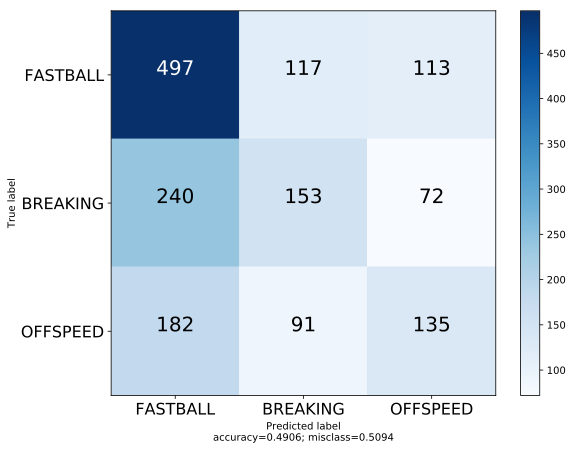

In [26]:
cm = confusion_matrix(y_test,y_pred)
names = ['FASTBALL','BREAKING','OFFSPEED']
title=''
plot_confusion_matrix(cm,names,normalize=False)

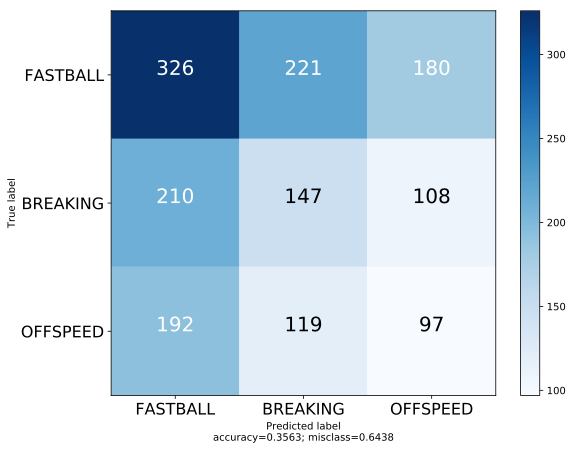

In [28]:
from sklearn.dummy import DummyClassifier

dummy_name = DummyClassifier

# instantiate and fit
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

# test dummy score
dummy_accuracy = dummy.score(X_test, y_test)

# we can even make predictions to the dummy
dummy_pred = dummy.predict(X_test)
cm = confusion_matrix(y_test,dummy_pred)
#names = ['1','2','3','4','5','6','7','8','9','11','12','13','14']
names = ['''''']
names = ['FASTBALL','BREAKING','OFFSPEED']
title=''
plot_confusion_matrix(cm,names,normalize=False)

In [29]:
print(classification_report(y_test,dummy_pred))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45       727
           1       0.30      0.32      0.31       465
           2       0.25      0.24      0.24       408

   micro avg       0.36      0.36      0.36      1600
   macro avg       0.33      0.33      0.33      1600
weighted avg       0.36      0.36      0.36      1600



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

In [ ]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

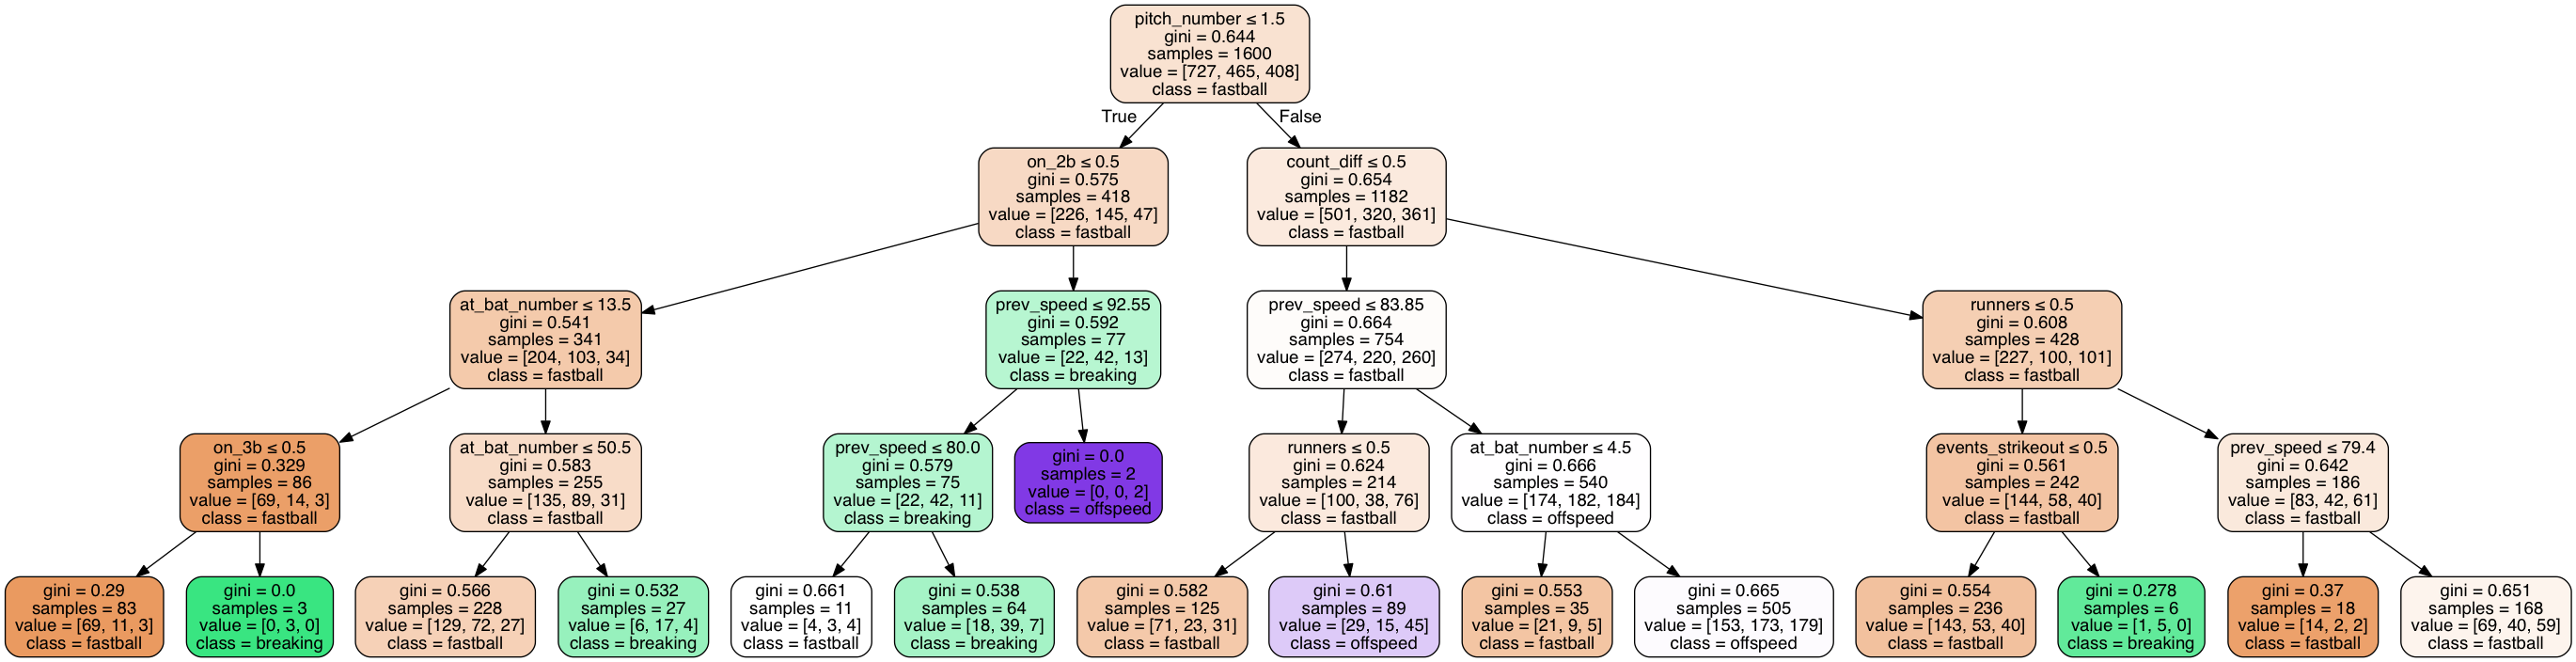

In [30]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_test, y_test)
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names = ['fastball','breaking','offspeed'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'svg'
graph.render('dtree_render',view=True)
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [31]:
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=42)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

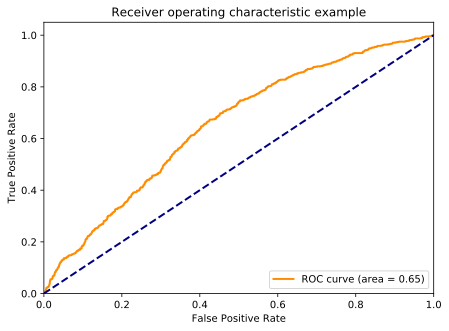

In [32]:
plt.figure(figsize=(7,5))

lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

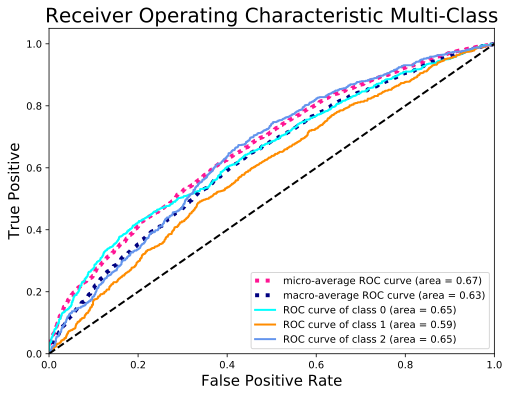

In [33]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive',fontsize=15)
plt.title('Receiver Operating Characteristic Multi-Class',fontsize=20)
plt.legend(loc="lower right")

plt.show()